In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from scipy.stats import ttest_ind
#from scipy.stats import mannwhitneyu
#from sklearn.cluster import KMeans

# Functions

In [2]:
def scatter_plot(df, x_col, y_col,
                 xlabel = None,
                 ylabel = None, 
                 x_lim=None, 
                 y_lim=None):

    plt.figure(figsize=(4, 4), dpi=150)
    plt.scatter(df[x_col], df[y_col], alpha=0.6)

    # --- Spearman correlation ---
    rho, p = spearmanr(df[x_col], df[y_col])

    label = f"Spearman ρ = {rho:.3f}\np = {p:.3f}"

    plt.text(
        0.05, 0.95, label,
        transform=plt.gca().transAxes,
        verticalalignment='top',
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.8)
    )

    # Set x and y labels
    if xlabel:
        plt.xlabel(xlabel)
    else:
        plt.xlabel(x_col.replace("_", " "))
    
    if ylabel:
        plt.ylabel(ylabel)
    else:
        plt.ylabel(y_col.replace("_", " "))

    # Fixed scale
    if x_lim is not None:
        plt.xlim(x_lim)

    if y_lim is not None:
        plt.ylim(y_lim)

    plt.tight_layout()
    plt.show()

def sprearman_correlation(df):
    cols = df.select_dtypes(include="number").columns
    pairs = []

    for i, c1 in enumerate(cols):
        for c2 in cols[i+1:]:
            x, y = df[c1], df[c2]
            mask = x.notna() & y.notna()
            n = int(mask.sum())
            if n > 2:
                r, p = spearmanr(x[mask], y[mask])
                pairs.append({"var1": c1, "var2": c2, "n": n, "spearman_r": r, "p_value": p})

    pairs_df = pd.DataFrame(pairs)
    return pairs_df


In [3]:
def beautiful_boxplot(
    df_list,
    labels,
    ylabel=None,
    xlabel=None,
    title=None,
    log_scale=False,
    colors=None,         # list of colors per box (optional)
    dot_size=20,
    jitter=0.06,
    figsize=(4.8, 4.2),
    dpi=200,
    show=True
):
    """
    df_list : list of pandas Series (or 1D arrays)
    labels  : list of group names (same length as df_list)
    colors  : list of colors for each box (same length as df_list) or None
    """

    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)

    # Clean data
    data = [np.asarray(d.dropna()) for d in df_list]

    # Boxplot
    bp = ax.boxplot(
        data,
        widths=0.55,
        patch_artist=True,
        showfliers=False,
        medianprops=dict(linewidth=1.5),
        whiskerprops=dict(linewidth=1.2),
        capprops=dict(linewidth=1.2),
        boxprops=dict(linewidth=1.2),
    )

    # Colors per box (or default)
    if colors is None:
        colors = ["lightgray"] * len(data)

    for patch, c in zip(bp["boxes"], colors):
        patch.set_facecolor(c)
        patch.set_alpha(0.55)

    # Overlay jittered dots
    for i, y in enumerate(data, start=1):
        x = np.random.normal(loc=i, scale=jitter, size=len(y))
        ax.scatter(x, y, alpha=0.65, s=dot_size, linewidths=0)

    # Styling
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.tick_params(axis="both", direction="out", length=4, width=1, labelsize=9)

    ax.set_xticks(range(1, len(labels) + 1))
    ax.set_xticklabels(labels, fontsize=9)

    if xlabel:
        ax.set_xlabel(xlabel, fontsize=10)
    if ylabel:
        ax.set_ylabel(ylabel, fontsize=10)
    if title:
        ax.set_title(title, fontsize=11, pad=10)

    if log_scale:
        ax.set_yscale("log")

    fig.tight_layout()

    if show:
        plt.show()

    return fig, ax


def _plot_foci_on_image(
    gray_image,
    df,
    x_col="x_px",
    y_col="y_px",
    r_col="sigma_px",
    circle_color="red",
    center_size=6,
    linewidth=1,
    figsize=(7, 7),
    dpi=200,
    title=None,
    show=True
):
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    ax.imshow(gray_image, cmap="gray")

    for x_px, y_px, r_px in zip(df[x_col], df[y_col], df[r_col]):
        ax.add_patch(
            Circle(
                (x_px, y_px),
                r_px,
                fill=False,
                edgecolor=circle_color,
                linewidth=linewidth
            )
        )
        ax.scatter(x_px, y_px, c=circle_color, s=center_size)

    ax.axis("off")

    if title:
        ax.set_title(title, fontsize=12, pad=10)

    fig.tight_layout()

    if show:
        plt.show()

    return fig, ax

# Data import

In [4]:
paths = [ "/mnt/c/users/Elena/Desktop/Data_processing/020226/WT_new_run/results.csv",
         "/mnt/c/users/Elena/Desktop/Data_processing/020226/MGS1_run/results.csv",
         "/mnt/c/users/Elena/Desktop/Data_processing/020226/MGS2_run/results.csv",
         "/mnt/c/users/Elena/Desktop/Data_processing/020226/MGS3_run/results.csv",
         "/mnt/c/users/Elena/Desktop/Data_processing/020226/MGS4_run/results.csv",
         "/mnt/c/users/Elena/Desktop/Data_processing/020226/MGS5_run/results.csv"
         ]
dfs = []
for p in paths:
    df = pd.read_csv(p)
    dfs.append(df)
print(f"Loaded {len(dfs)} dataframes.")

Loaded 6 dataframes.


# Correlation matrix and scatter plots

In [ ]:
corr = sprearman_correlation(df)
#corr = corr[corr['p_value'] < 0.05]

for v1, v2 in zip(corr['var1'], corr['var2']):
    scatter_plot(df, x_col = v1, y_col = v2)

# Boxplots

In [14]:
labels=["WT", "MGS1", "MGS2", "MGS3", "MGS4", "MGS5"]
args = [{'var': "Foci_number", 'ylabel':'Count', 'title':'Number of foci'},
        {'var': "All_foci_sigma_nm", 'ylabel':'nm', 'title': 'Foci size (sigma)'},
        {'var': "All_foci_MFI_px", 'ylabel':'', 'title': 'MFI of foci'},
        {'var': "Outliers_number", 'ylabel':'Count', 'title': 'Number of outliers'},
        {'var': "Outliers_sigma_nm", 'ylabel':'nm', 'title':'Outliers size (sigma)'},
        {'var': "Outliers_MFI_px", 'ylabel':'', 'title':'MFI of outliers'}
]

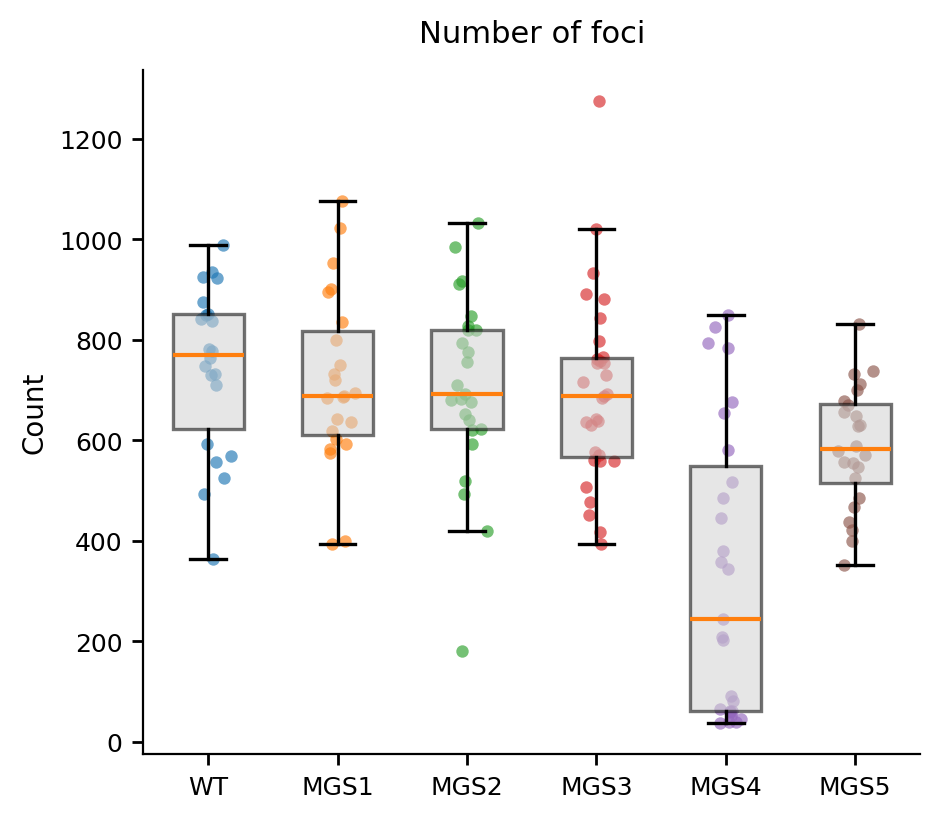

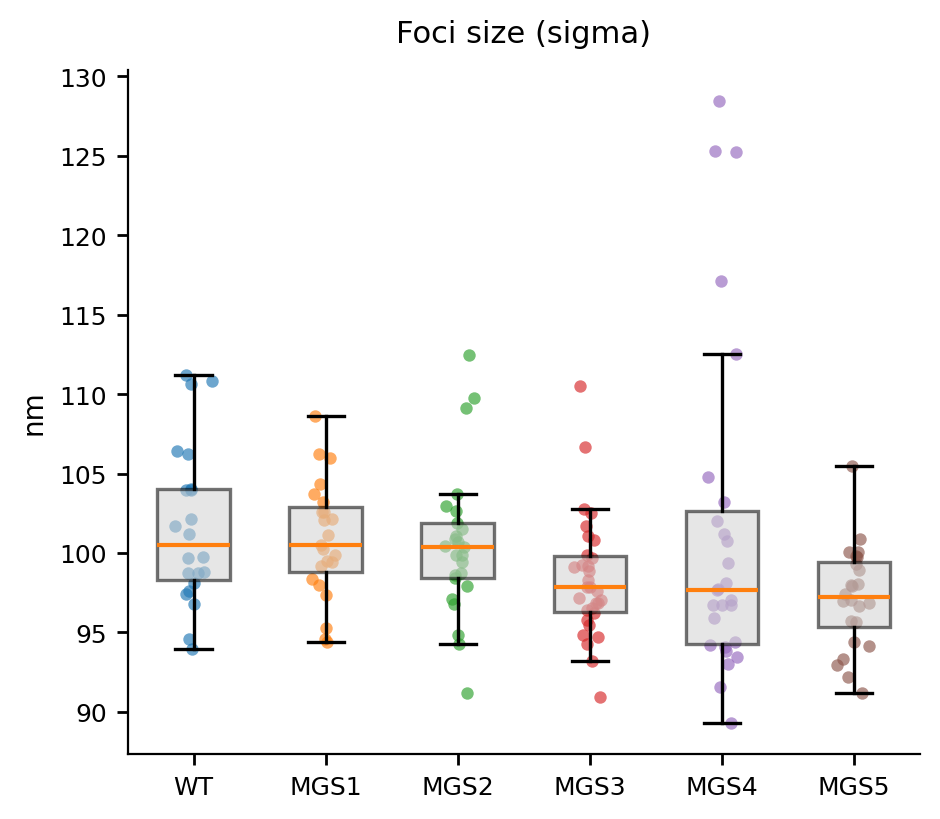

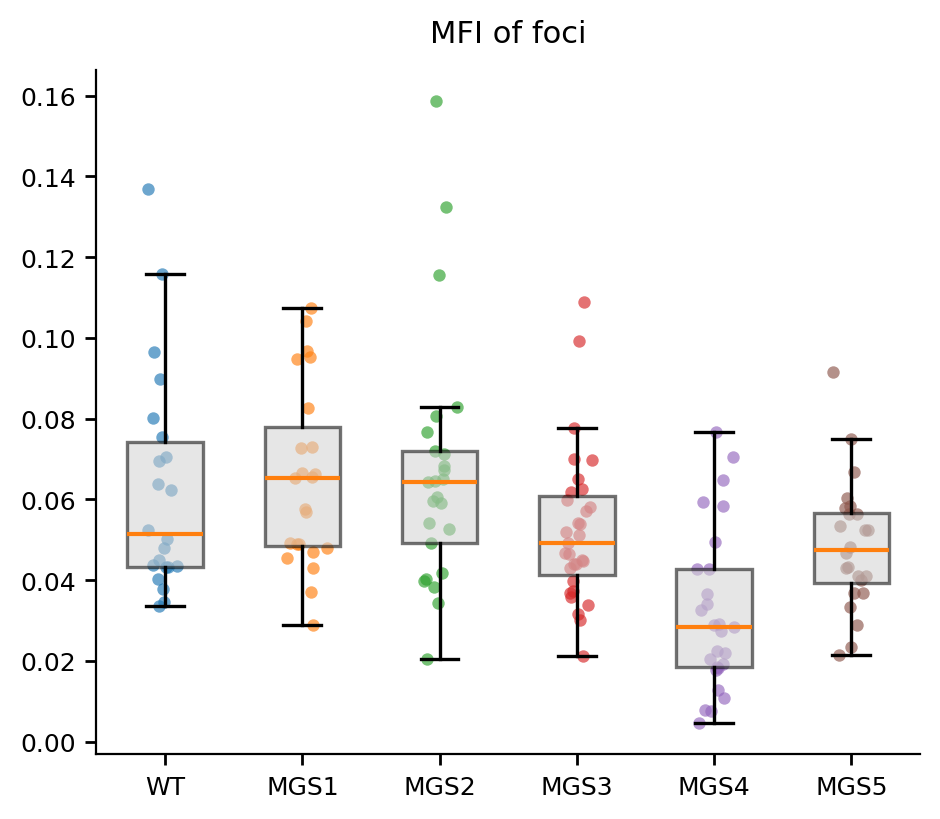

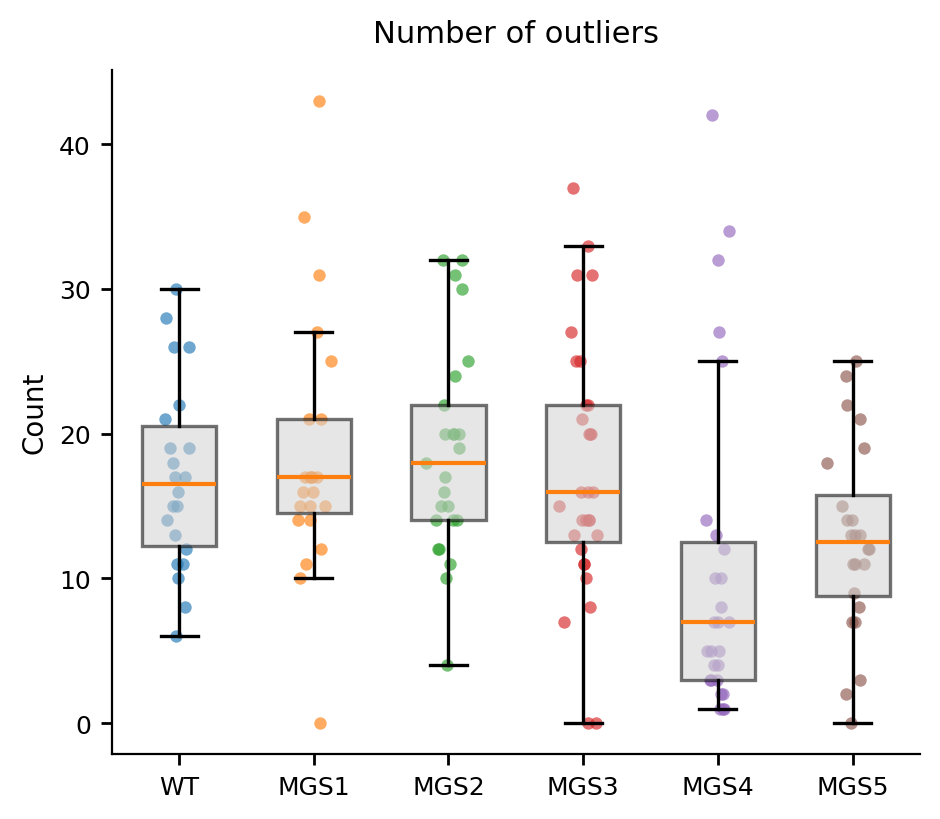

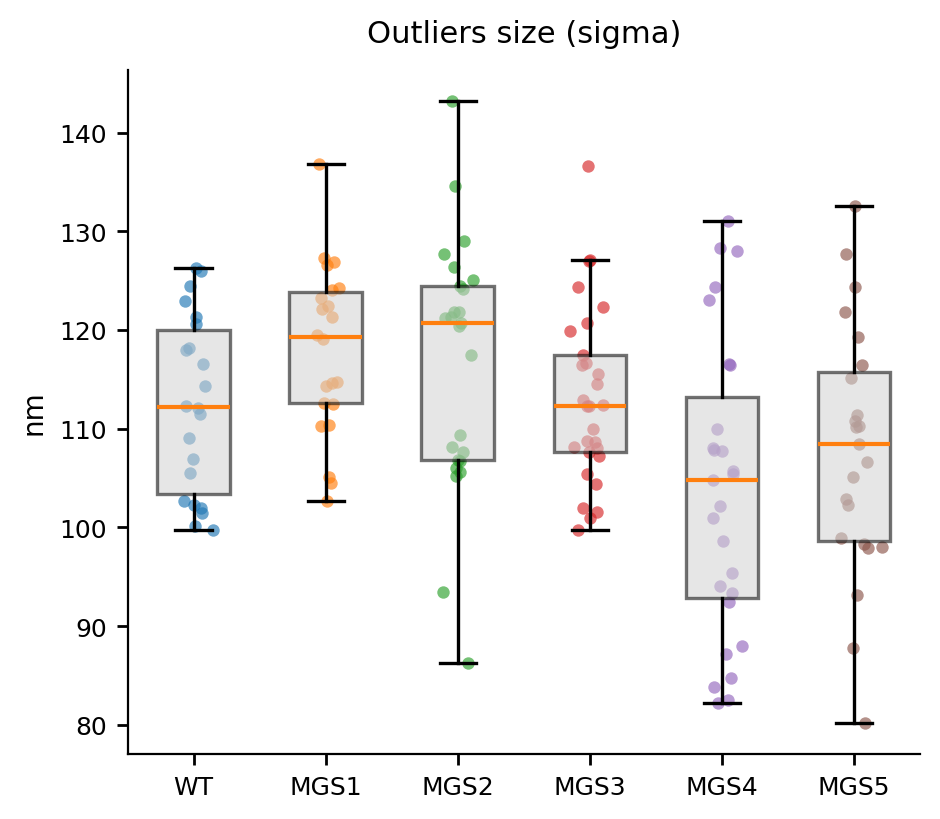

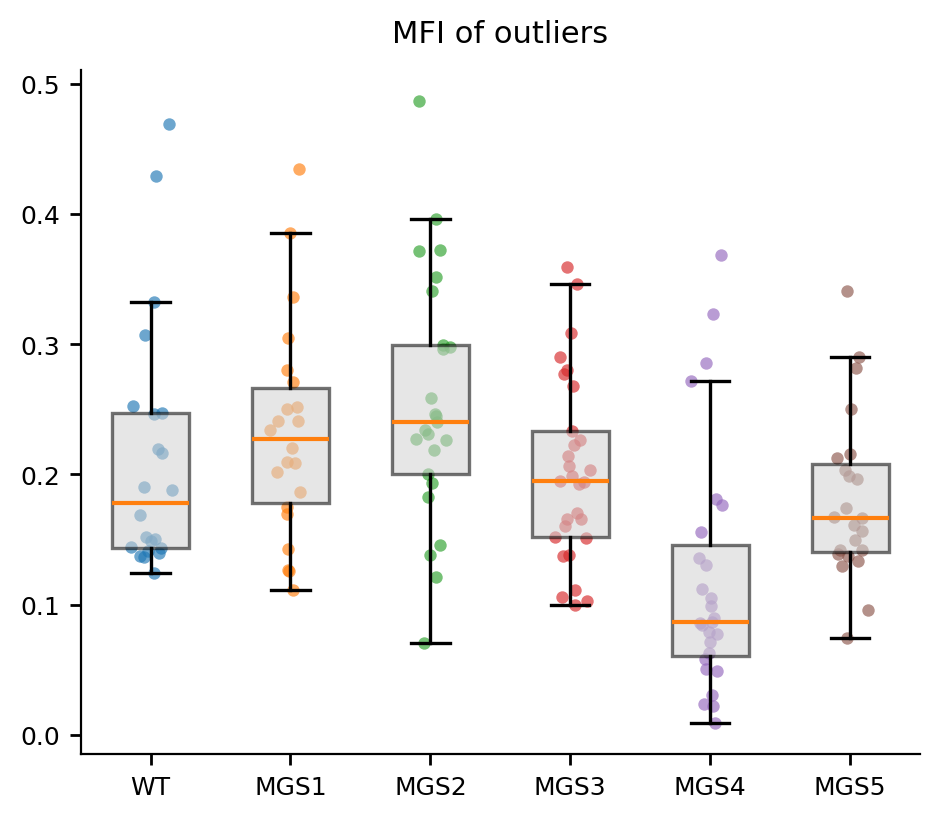

In [15]:
for arg in args:
    beautiful_boxplot(
        df_list=[
                dfs[0][arg['var']],
                dfs[1][arg['var']],
                dfs[2][arg['var']],
                dfs[3][arg['var']],
                dfs[4][arg['var']],
                dfs[5][arg['var']]
                ],
        labels=labels,
        ylabel=arg['ylabel'],
        title=arg['title']
    )

# T-test

In [ ]:
dfs[0].columns

In [ ]:
reference = dfs[0]
col = "All_foci_MFI_px"

results = []

for i in range(1, len(dfs)):
    group = dfs[i]

    # Drop NaNs
    x = reference[col].dropna()
    y = group[col].dropna()

    t_stat, p_value = ttest_ind(x, y, equal_var=True)

    results.append({
        "comparison": f"dfs[0] vs dfs[{i}]",
        "t_stat": t_stat,
        "p_value": p_value,
        'significant' : p_value < 0.05
    })

for r in results:
    print(r)

## Draw circle area (draft)

In [ ]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(gray, cmap="gray")

for x_px, y_px, r_px in zip(res["x_px"], res["y_px"], res["sigma_px"]):
    # circle outline
    ax.add_patch(Circle((x_px, y_px), r_px, fill=False, edgecolor="red", linewidth=1))
    # center dot
    ax.scatter(x_px, y_px, c="red", s=6)

ax.axis("off")
plt.show()

# Kmean (draft)

In [ ]:
n_clusters = 3

# Select TWO columns
X = df[["mean_intensity", "sigma [nm]"]].dropna()

# Run KMeans
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(X)

# Add cluster labels back to dataframe
df.loc[X.index, "cluster"] = labels

centers = kmeans.cluster_centers_

print("Cluster centers:")
for i, c in enumerate(centers):
    print(f"Cluster {i}: mean_intensity={c[0]:.2f}, sigma={c[1]:.2f}")

In [ ]:
plt.figure(figsize=(5, 4), dpi=200)

# Scatter plot of clusters
for cluster_id in range(n_clusters):
    cluster_data = df[df["cluster"] == cluster_id]
    plt.scatter(cluster_data["sigma [nm]"],
                cluster_data["mean_intensity"],
                alpha=0.6,
                label=f"Cluster {cluster_id}")

# Plot cluster centers
plt.scatter(centers[:, 1],   # sigma
            centers[:, 0],   # mean_intensity
            marker="X",
            s=200,
            linewidths=2,
            edgecolors="black",
            label="Centers")

plt.xlabel("Sigma")
plt.ylabel("Mean intensity")
plt.title("KMeans Clustering (Sigma vs Intensity)")
plt.legend()

# Clean look
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.show()
